# Compute global annual anomalies

In [61]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.signal import detrend
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import xarray as xr
import intake
import pprint 
import util 
import os

## define functions
def calendar_check_new(model):
    calendarfile = '../Processed_data/Calendars/' + model + '_calendars.txt'
    cal_df = pd.read_table(calendarfile, index_col=0, sep = ' ')
    calendars_used = cal_df['calendar'].drop_duplicates()
    # I think 365 days calendar must be the same as noleap
    return calendars_used.values[0]

def calendar_check_old(model):
    # Time formats for piControl, found from manual check:
    if model in ['TaiESM1', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'FGOALS-f3-L', 'FGOALS-g3', 'CanESM5', 'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA', 'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorCPM1', 'NorESM1-F', 'NorESM2-LM', 'NorESM2-MM', 'GFDL-CM4', 'SAM0-UNICON', 'GFDL-ESM4', 'CIESM', 'MCM-UA-1-0']:
        ds_calendar = 'noleap'
    elif model in ['CNRM-CM6-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'NESM3']:
        ds_calendar = 'gregorian'
    elif model in ['AWI-CM-1-1-MR', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR']:
        ds_calendar = 'proleptic_gregorian'
    elif model in ['UKESM1-0-LL', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'CNRM-ESM2-1', 'KACE-1-0-G', 'MRI-ESM2-0']:
        ds_calendar = '360_day'
        if model in ['CNRM-ESM2-1', 'MRI-ESM2-0']:
            print('piControl is 360_day, the other experiments unknown')
    elif model in ['IITM-ESM']:
        ds_calendar = 'Julian'
    elif model in ['AWI-ESM-1-1-LR', 'CNRM-CM6-1-HR', 'EC-Earth3', 'EC-Earth3-LR']:
        #ds_calendar = 'datetime64'
        print('not 100% sure what calendar this model has, but a guess is made based on other models from same institution')
        if model in ['EC-Earth3', 'EC-Earth3-LR', 'AWI-ESM-1-1-LR']:
            print('calendar is likely proleptic gregorian')
            ds_calendar = 'proleptic_gregorian'
        elif model in ['CNRM-CM6-1-HR']:
            print('calendar is likely gregorian')
            ds_calendar = 'gregorian'
    return ds_calendar

# function copied from: http://xarray.pydata.org/en/stable/examples/monthly-means.html
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap


# days per month:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'julian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], ##### I think this should be correct
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
      }

# days per year
def dpy(model, start_year, end_year):
    ds_calendar = calendar_check_new(model) 
    leap_boolean = [leap_year(year, calendar = ds_calendar) for year in range(start_year, end_year)]
    leap_int = np.multiply(leap_boolean,1)
    
    noleap_dpy = np.array(dpm[ds_calendar]).sum()
    leap_dpy = noleap_dpy + leap_int
    return leap_dpy  

## Choose model and experiment

In [199]:
#model = 'HadGEM3-GC31-LL'
model = 'CNRM-ESM2-1'


#exp = 'piControl'
# = 'abrupt-4xCO2'
#exp = 'abrupt-2xCO2'
#exp = 'abrupt-0p5xCO2'

#exp = 'historical'
#exp = 'ssp126'
#exp = 'ssp245'
#exp = 'ssp370'
exp = 'ssp585'

In [200]:
branch_time_file = '../Processed_data/Branch_times/' + model + '_branch_times.txt'
table = pd.read_table(branch_time_file,index_col=0, sep = ' ')
#pd.set_option('display.max_rows', None)
pd.set_option('display.min_rows', 15)
table

,model,exp,member,parent_experiment_id,parent_variant_id,branch_time_in_child,branch_time_in_parent,parent_time_units,branch_method
0,CNRM-ESM2-1,abrupt-4xCO2,r1i1p1f2,piControl,r1i1p1f2,0.0,0.0,days since 1850-01-01 00:00:00,standard
1,CNRM-ESM2-1,abrupt-4xCO2,r2i1p1f2,piControl,r2i1p1f2,0.0,12053.0,days since 1850-01-01 00:00:00,standard
2,CNRM-ESM2-1,abrupt-4xCO2,r3i1p1f2,piControl,r1i1p1f2,0.0,33237.0,days since 1850-01-01 00:00:00,standard
3,CNRM-ESM2-1,ssp245,r1i1p1f2,historical,r1i1p1f2,60265.0,60265.0,days since 1850-01-01 00:00:00,standard
4,CNRM-ESM2-1,ssp245,r2i1p1f2,historical,r2i1p1f2,60265.0,60265.0,days since 1850-01-01 00:00:00,standard
5,CNRM-ESM2-1,ssp245,r3i1p1f2,historical,r3i1p1f2,60265.0,60265.0,days since 1850-01-01 00:00:00,standard
6,CNRM-ESM2-1,ssp245,r4i1p1f2,historical,r4i1p1f2,60265.0,60265.0,days since 1850-01-01 00:00:00,standard
7,CNRM-ESM2-1,ssp245,r5i1p1f2,historical,r5i1p1f2,60265.0,60265.0,days since 1850-01-01 00:00:00,standard
8,CNRM-ESM2-1,historical,r10i1p1f2,piControl,r1i1p1f2,0.0,58804.0,days since 1850-01-01 00:00:00,standard
9,CNRM-ESM2-1,historical,r11i1p1f2,piControl,r1i1p1f2,0.0,47481.0,days since 1850-01-01 00:00:00,standard


0.0
0
days difference: 0.0
differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year
12053.0
12053
days difference: 0.0
differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year
33237.0
33238
days difference: 1.0
differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year
40176.0
40177
days difference: 1.0
differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year
51134.0
51135
days difference: 1.0
differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year


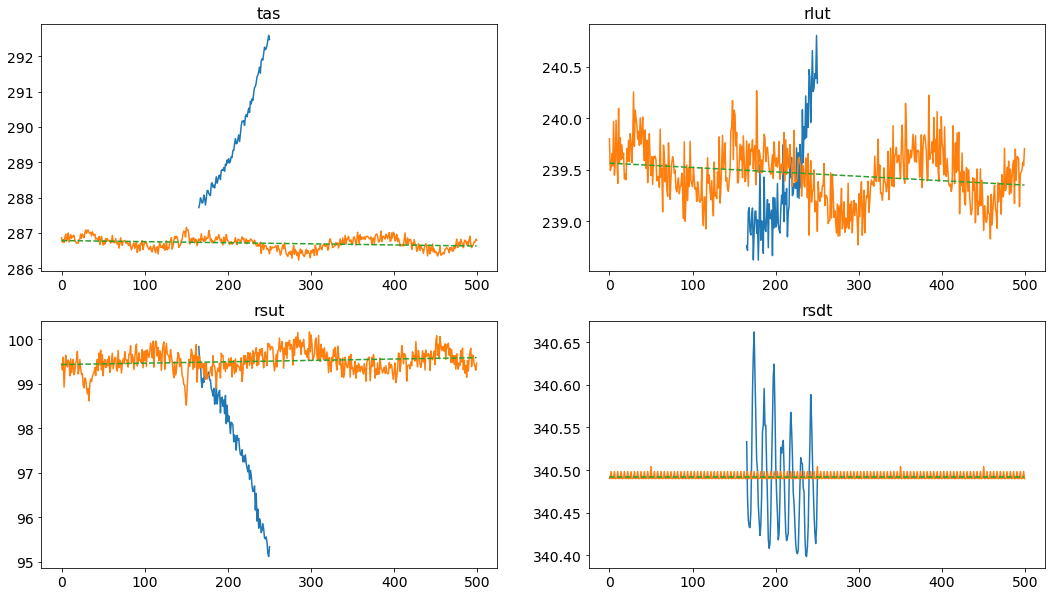

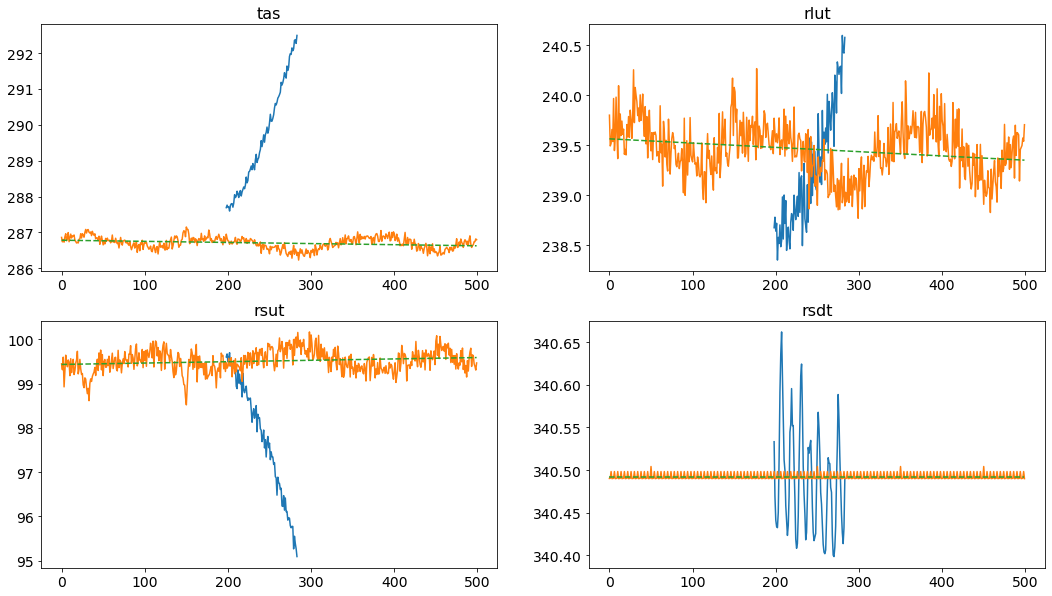

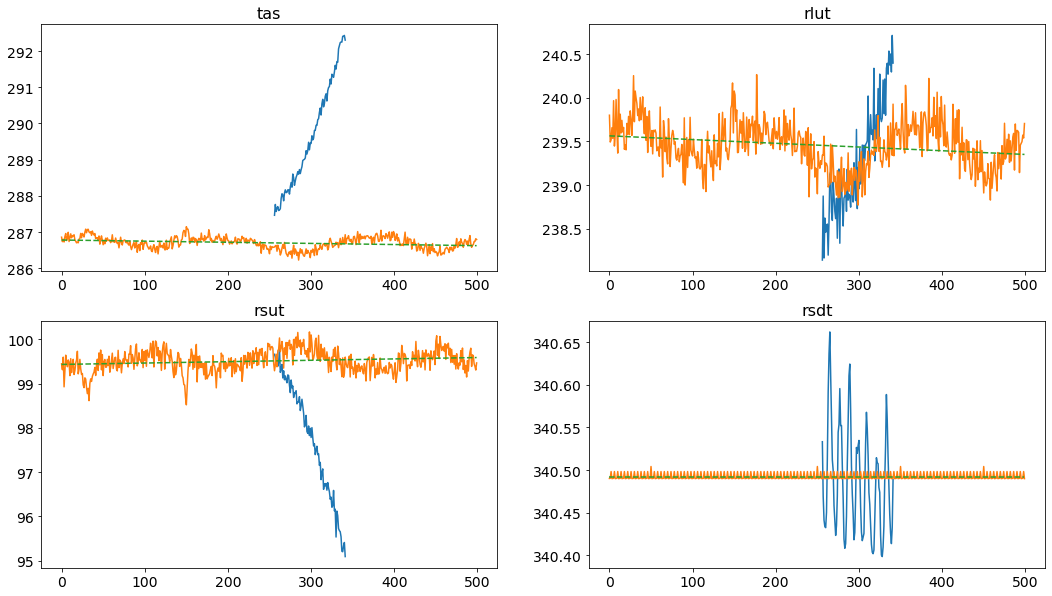

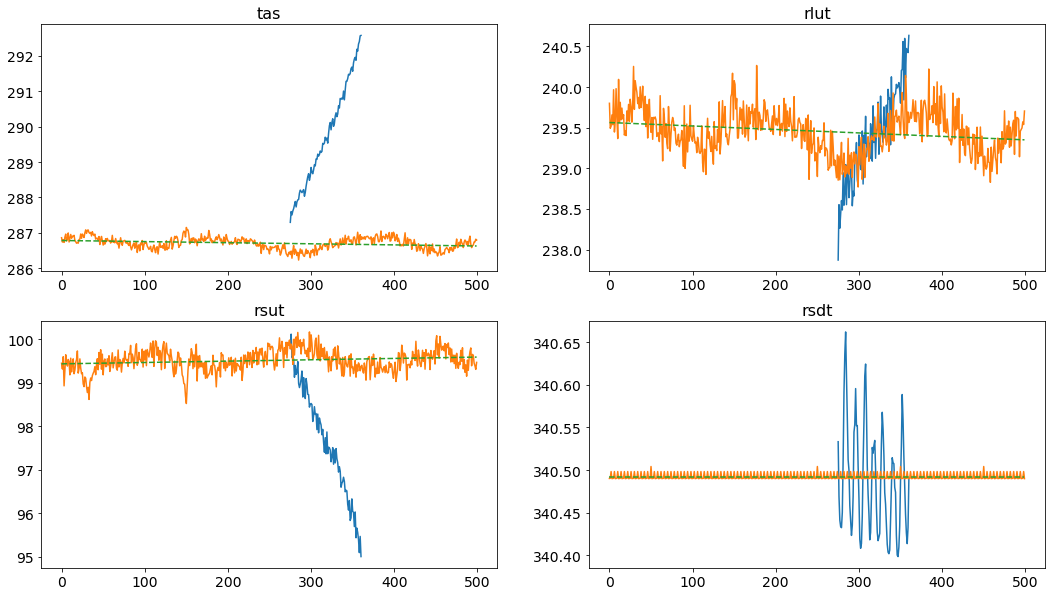

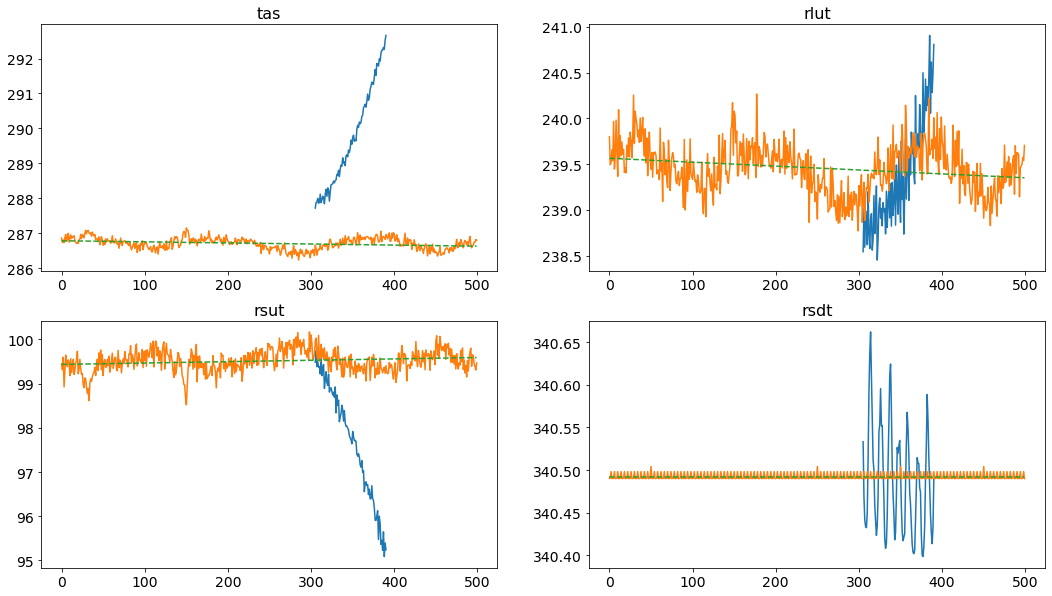

In [201]:
plot_absolute_values = True
plot_anomalies = False
save_results = True
#save_results = False

expgroup0 = ['piControl']
expgroup1 = ['abrupt-4xCO2', 'abrupt-2xCO2', 'abrupt-0p5xCO2']
expgroup2 = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

piControl_path = '../Processed_data/Global_annual_means/' + model + '/piControl/'
exp_path = '../Processed_data/Global_annual_means/' + model + '/' + exp + '/'

exptable = table.loc[table['exp'] == exp]
available_members = exptable['member'].values

for member in available_members:
    member_df = exptable.loc[exptable['member'] == member]

    # load exp data
    exp_filename = model + '_' + exp + '_' + member + '_means.txt'
    exp_data = pd.read_table(exp_path + exp_filename, index_col=0, sep = ',')
    
    if plot_absolute_values == True:
        fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [18,10]); axes = np.reshape(ax, 4)
    if plot_anomalies == True:
        fig, ax2 = plt.subplots(nrows = 2, ncols = 2, figsize = [18,10]); axes2 = np.reshape(ax2, 4)

    if exp in expgroup1 or exp in expgroup2:
        if exp in expgroup1 or exp == 'historical':
            branch_time_days = member_df['branch_time_in_parent'].values[0]
            piControl_member = member_df['parent_variant_id'].values[0] 
        elif exp in expgroup2: # then ssp. check branch for historical parent only
            # find historical parent member 
            parent_member = member_df['parent_variant_id'].values[0]
            parent_table = table.loc[table['exp'] == 'historical']
            parent_df = parent_table.loc[parent_table['member'] == parent_member]
            branch_time_days = parent_df['branch_time_in_parent'].values[0]
            piControl_member = parent_df['parent_variant_id'].values[0]
        if model in ['MPI-ESM1-2-HR', 'BCC-CSM2-MR', 'INM-CM5-0'] and exp in expgroup2:
            piControl_member = 'r1i1p1f1' # overwrite info from file, which seems to be wrong
        if model in ['NorESM2-LM'] and exp == 'ssp370':
            parent_member = member # overwrite info in file which is likely wrong
            parent_df = parent_table.loc[parent_table['member'] == parent_member]
            branch_time_days = parent_df['branch_time_in_parent'].values[0]
            piControl_member = parent_df['parent_variant_id'].values[0]
        if model in ['IPSL-CM6A-LR'] and exp == 'historical' and member == 'r32i1p1f1': 
            piControl_member = 'r1i1p1f1' # overwrite info saying that piControl member is also 'r32i1p1f1'
        if model in ['CNRM-CM6-1', 'CNRM-ESM2-1'] and exp == 'abrupt-4xCO2':
            piControl_member = 'r1i1p1f2' # this is the only control run available
            # many CNRM-CM6-1 historical branch times are after the end of picontrol in , but I find no errata info about this. Maybe a later period of piControl is just not available
            
        # load piControl values. 
        piControl_filename = model + '_piControl_' + piControl_member + '_means.txt'
        piControl_data = pd.read_table(piControl_path + piControl_filename, index_col=0, sep = ',')
        
        piControl_start_year = int(table.loc[table['parent_experiment_id'] == 'piControl']['parent_time_units'][0][11:15]) # wrong for several models
        days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+1500)))    
        # find index of element closest to branch_time_days
        year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
        if model in ['BCC-CSM2-MR', 'BCC-ESM1'] and exp in expgroup2: # models with branch time given in years instead of days
            year_since_piControl_start = int(branch_time_days - piControl_start_year)
            print('year_since_piControl_start is', year_since_piControl_start)
        elif model in ['CAMS-CSM1-0']: # branch times given in years instead of days for all experiments except piControl
            piControl_start_year = 2900
            year_since_piControl_start = int(branch_time_days - piControl_start_year)
            print('year_since_piControl_start is', year_since_piControl_start)
        elif model in ['NorESM2-LM']:
            piControl_start_year = 1600
            if exp in expgroup1:
                year_since_piControl_start = 0 # because 4xCO2 branch time is the same as piControl branch time
            elif exp in expgroup2: # measure branch time relative to r1 member
                if member == 'r1i1p1f1':
                    year_since_piControl_start = 0
                else:
                    days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+500)))
                    branch_time_days = branch_time_days - 430335
                    # find index of element closest to branch_time_days
                    year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
                    print(member)
                    print(year_since_piControl_start)
                    print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
        elif model in ['NorESM2-MM']:
            piControl_start_year = 1200
            year_since_piControl_start = 0 # because 4xCO2 branch time is the same as piControl branch time
        elif model in ['UKESM1-0-LL']:
            piControl_start_year = 1960
            if exp in expgroup1:
                year_since_piControl_start = 0
            elif exp in expgroup2:
                days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+1000)))
                branch_time_days = branch_time_days - 39600
                # find index of element closest to branch_time_days
                year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
                print(member)
                print(year_since_piControl_start)
                print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
        elif model in ['GFDL-CM4']:
            piControl_start_year = 151 # found from manual check. Branch info is clearly wrong, since it lists different time units for piControl
            if exp == 'abrupt-4xCO2':
                year_since_piControl_start = 0
            elif exp in expgroup2:
                year_since_piControl_start = 100 # probably?
        elif model == 'CanESM5': 
            if exp in expgroup1:
                year_since_piControl_start = 0 # because 4xCO2 branch time is the same as piControl branch time
            elif exp in expgroup2: # measure branch time relative to r1 member
                piControl_start_year = 5201
                days_table = np.append([0],np.cumsum(dpy(model,piControl_start_year,piControl_start_year+2000)))  
                if int(member[-3]) == 1:
                    branch_time_days = branch_time_days - 1223115 
                elif int(member[-3]) == 2:
                    branch_time_days = branch_time_days - 1350500
                # find index of element closest to branch_time_days
                year_since_piControl_start = (np.abs(days_table - branch_time_days)).argmin()
                print(member)
                print(year_since_piControl_start)
                print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
        else:
            print(branch_time_days)
            print(days_table[year_since_piControl_start])
            print('days difference:', days_table[year_since_piControl_start] - branch_time_days)
            print('differences not equal to 0 indicate wrong calendar assumptions or branch dates not equal to the start of a new year')
        
    for (i,var) in enumerate(['tas', 'rlut', 'rsut', 'rsdt']):
        ydata = exp_data[var]
        exp_len = len(exp_data[var])
        if exp in expgroup0:
            # then just subtract a linear trend from all values
            y = exp_data[var]; 
            y = y[np.isnan(y) == False] # needed for some models with several piControl members. 
            # Saved data should be manually checked if different variables exist for different periods
            # because this code makes them all to start at time 0.
            x = np.arange(len(y))
            datarange = np.arange(len(y))
        elif exp in expgroup1:
            y = piControl_data[var] # use all piControl years to determine trend
            y = y[np.isnan(y) == False]
            x = np.arange(len(y))
            #y = piControl_data[var][year_since_piControl_start:(year_since_piControl_start+exp_len)] # Use only years corresponding to exp years
            #x = np.arange(exp_len)
            datarange = year_since_piControl_start + np.arange(exp_len)
        elif exp in expgroup2:
            #x = np.arange(251) # number of years in interval (1850 - 2100)
            y = piControl_data[var] # use all piControl years to determine trend
            y = y[np.isnan(y) == False]
            x = np.arange(len(y))
            #y = piControl_data[var][year_since_piControl_start:(year_since_piControl_start+251)] # Use historical + ssp years (1850 - 2100)
            if exp == 'historical':
                datarange = year_since_piControl_start + np.arange(165)
            else:
                datarange = year_since_piControl_start + np.arange(165,251)
                ydata = ydata[:86] # if data exists beyond year 2100, this code excludes them
                if model == 'CAMS-CSM1-0': # stops in 2099
                    datarange = year_since_piControl_start + np.arange(165,250)
                elif model == 'BCC-ESM1': # ssp370 has only 40 years of data
                    datarange = year_since_piControl_start + np.arange(165,206)

        #if len(y) == len(x):
        #    p1 = np.polyfit(x,y,1)
        #elif len(y) < len(x):
        #    p1 = np.polyfit(x[:len(y)],y,1) # make a fit from the data we have available
        #lintrend = np.polyval(p1,x)
        p1 = np.polyfit(x,y,1)
        lintrend = np.polyval(p1,np.arange(max(len(x), datarange[-1]+1))) # make trend longer than x, in case exp ends later than piControl  
        if exp in expgroup0:
            annual_anomalies = y - lintrend[datarange]
        else:
            annual_anomalies = ydata - lintrend[datarange]
        if var == 'tas':
            # create dataframe for storing anomalies
            exp_anomalies = pd.DataFrame(annual_anomalies.values, columns = [var])
        else:
            df_col = pd.DataFrame(annual_anomalies.values, columns = [var])
            exp_anomalies = pd.merge(exp_anomalies, df_col, left_index=True, right_index=True, how='outer')

        if plot_absolute_values == True: # plot abolute values and trends
            if exp in expgroup0:
                axes[i].plot(datarange, y) # exp data
            else:
                axes[i].plot(datarange, ydata) # exp data
            #axes[i].plot(x[:len(y)], y)
            axes[i].plot(x, y) # piControl
            axes[i].plot(np.arange(len(lintrend)), lintrend, '--') # piControl trend
            #axes[i].plot(x, lintrend[:len(x)]) # piControl trend
            axes[i].set_title(var, fontsize = 16)
            axes[i].tick_params(axis='both',labelsize=14)
        if plot_anomalies == True: # plot anomalies for visual check:
            axes2[i].plot(x, exp_anomalies[var])
            axes2[i].set_title(x, var, fontsize = 16)
            axes2[i].tick_params(axis='both',labelsize=14) 

    if save_results == True:
        filename = model + '_' + exp + '_' + member + '_anomalies.txt'
        file = os.path.join('../Processed_data/Global_annual_anomalies/', model, exp, filename)
        if member == available_members[0]: # create directory for first member
            os.makedirs(os.path.dirname(file), exist_ok=False)

        exp_anomalies.to_csv(file)
        

In [202]:
exp_anomalies

,tas,rlut,rsut,rsdt
0,1.029522,-0.891333,-0.044912,0.040981
1,1.190632,-0.420682,0.212542,-0.023152
2,1.202677,-0.841072,-0.147591,-0.050859
3,1.308179,-0.442915,-0.036188,-0.058573
4,1.170537,-0.566776,-0.155913,-0.059730
5,1.205028,-0.812753,-0.152602,-0.041689
6,1.433653,-0.231743,-0.312920,0.021205
7,1.188320,-0.690335,0.050624,0.099058
8,1.264812,-0.852111,-0.351735,0.143738
9,1.371482,-0.530642,-0.197415,0.169637
